## **Time-Series Deep Learning Models of a Electrolyzer**


Jake Immonen, Jiwei Yao, Scott Springer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io
import numpy as np
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt


**Data Import and Arranging** \\
First, data from the electrolyzer simulaiton needs to be imported into memory. The data is in the form of a .mat file which is what is standard file saving for MATLAB/Simulink. Scipy has an easy load function.

In [3]:
data = scipy.io.loadmat('big_data_cont.mat')
dataNP = data['big_data'] #takes dictionary value and numpy array
datasize = dataNP.shape[0]
trainsize = int(0.8 * datasize)

**Convert to DataFrame and Visuzlize** \\
Next, the data can be converted to a Pandas dataframe for the training and testing set. Also we decided to only look at every 6 data points to convert the data to minutes timeframe and reduces computationaly complexity without losing much info because the dynamcis happen on a minutes timeframe rather than a seconds timeframe.

In [4]:
dataPDtrain = pd.DataFrame(dataNP[0:trainsize,:], columns = ['T_Cin','T_Ain','m_Ain', 'm_Cin', 'c_H2in', 'j_avg', 'T_out', 'conv', 'U'])
dataPDtest = pd.DataFrame(dataNP[trainsize:,:], columns = ['T_Cin','T_Ain','m_Ain', 'm_Cin', 'c_H2in', 'j_avg', 'T_out', 'conv', 'U'])
dataPDtrain = dataPDtrain.iloc[::6, :] #convert to mintute timesteps - 10 seconds are just too fine
dataPDtest = dataPDtest.iloc[::6, :]  #convert to minute timesteps - 10 seconds are just too fine


In [20]:
dataPDtrain.describe()

,T_Cin,T_Ain,m_Ain,m_Cin,c_H2in,j_avg,T_out,conv,U
count,352080.000000,352080.000000,352080.000000,352080.000000,352080.000000,352080.000000,352080.000000,352080.000000,352080.000000
mean,1072.323165,1073.307252,7.862916,7.722838,1.192842,5298.923824,1081.399602,0.767209,1.289756
std,20.392958,20.097950,0.597202,0.648206,0.162885,662.108205,27.575033,0.089403,0.014991
min,1023.019316,1023.095586,6.000146,6.000140,0.800033,4000.081203,955.773892,0.514472,1.232874
25%,1063.499941,1065.902235,7.679143,7.383600,1.127024,5034.955563,1070.305382,0.733040,1.285609
50%,1072.985927,1073.004807,7.998247,7.977640,1.199864,5168.443710,1073.918206,0.736906,1.287092
75%,1079.325821,1080.827247,8.106576,8.008600,1.248865,5496.158945,1090.094024,0.815909,1.296433
max,1122.976636,1122.954357,8.999927,8.997488,1.599349,7959.764307,1213.074978,0.992902,1.344386


In [6]:
dataPDtest.describe()

,T_Cin,T_Ain,m_Ain,m_Cin,c_H2in,j_avg,T_out,conv,U
count,88020.000000,88020.000000,88020.000000,88020.000000,88020.000000,88020.000000,88020.000000,88020.000000,88020.000000
mean,1074.147534,1073.447979,7.851147,7.775128,1.190429,5258.377551,1080.144190,0.763014,1.288512
std,20.745754,20.281260,0.603524,0.623429,0.157986,594.109079,24.835978,0.086730,0.014678
min,1023.490810,1023.599302,6.095123,6.033155,0.800538,4003.040283,1010.449790,0.514246,1.229612
25%,1066.319135,1065.479420,7.624198,7.525415,1.122844,5018.514268,1068.536629,0.729447,1.283851
50%,1073.004479,1073.010995,7.997988,7.993649,1.199800,5167.302498,1073.717230,0.735236,1.287048
75%,1083.271659,1080.973995,8.101978,8.033962,1.242969,5424.423879,1089.881109,0.805104,1.295316
max,1122.996153,1122.899280,8.995570,8.969684,1.598185,7438.833890,1175.718892,0.992231,1.338136


Text(0.5, 0, 'Time (min)')

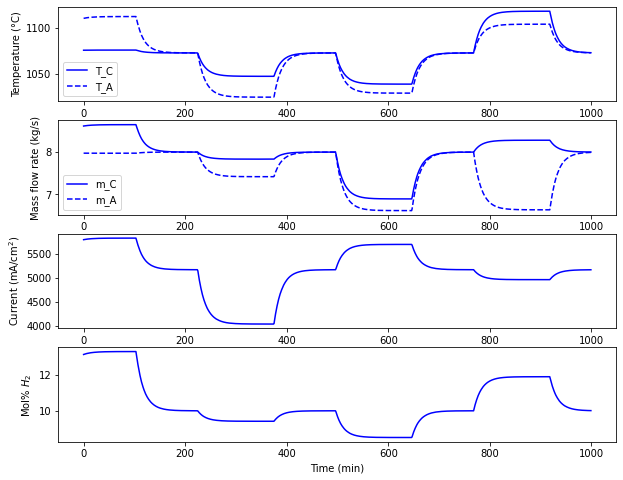

In [35]:
start = 10100
stop = start + 1000

time = np.linspace(0, 1000-1, stop-start)

plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(time, dataPDtrain['T_Cin'][start:stop],'b-',label='T_C')
plt.plot(time, dataPDtrain['T_Ain'][start:stop],'b--',label='T_A')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.subplot(4,1,2)
plt.plot(time, dataPDtrain['m_Cin'][start:stop],'b-',label='m_C')
plt.plot(time, dataPDtrain['m_Ain'][start:stop],'b--',label='m_A')
plt.legend()
plt.ylabel('Mass flow rate (kg/s)')
plt.subplot(4,1,3)
plt.plot(time, dataPDtrain['j_avg'][start:stop],'b-')
plt.ylabel('Current (mA/cm$^2$)')
plt.subplot(4,1,4)
plt.plot(time, dataPDtrain['c_H2in'][start:stop]/12*100,'b-')
plt.ylabel('Mol% $H_2$')
plt.xlabel('Time (min)')


Text(0.5, 0, 'Time (min)')

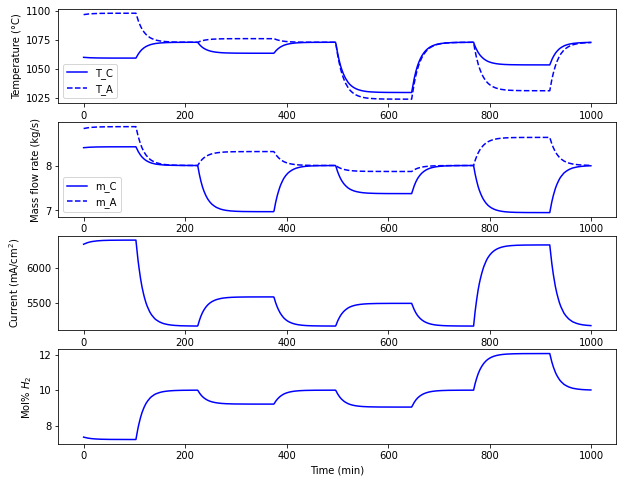

In [36]:
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(time, dataPDtest['T_Cin'][start:stop],'b-',label='T_C')
plt.plot(time, dataPDtest['T_Ain'][start:stop],'b--',label='T_A')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.subplot(4,1,2)
plt.plot(time, dataPDtest['m_Cin'][start:stop],'b-',label='m_C')
plt.plot(time, dataPDtest['m_Ain'][start:stop],'b--',label='m_A')
plt.legend()
plt.ylabel('Mass flow rate (kg/s)')
plt.subplot(4,1,3)
plt.plot(time, dataPDtest['j_avg'][start:stop],'b-')
plt.ylabel('Current (mA/cm$^2$)')
plt.subplot(4,1,4)
plt.plot(time, dataPDtest['c_H2in'][start:stop]/12*100,'b-')
plt.ylabel('Mol% $H_2$')
plt.xlabel('Time (min)')


In [7]:
scaler1 = MinMaxScaler(feature_range = (-1,1)) #scale between -1 and 1
scaler2 = MinMaxScaler(feature_range = (-1,1)) #scale between -1 and 1

#training data
Xs = scaler1.fit_transform(dataPDtrain[['T_Cin','T_Ain','m_Ain', 'm_Cin', 'c_H2in', 'j_avg', 'T_out', 'conv', 'U']]) #our inputs are the MVs and CVs
Ys = scaler2.fit_transform(dataPDtrain[['T_out', 'conv', 'U']]) #our inputs are the CVs - what we want to predict

#testing data
Xst = scaler1.fit_transform(dataPDtest[['T_Cin','T_Ain','m_Ain', 'm_Cin', 'c_H2in', 'j_avg', 'T_out', 'conv', 'U']]) #our inputs are the MVs and CVs
Yst = scaler2.fit_transform(dataPDtest[['T_out', 'conv', 'U']]) #our inputs are the CVs - what we want to predict



In [8]:
window = 30 #timesteps we want to use (30 minutes)

#empty lists for test
X = []
Y = []

#and train
Xt = []
Yt = []

for i in range(window,len(Xs)):
    #test
    X.append(Xs[i-window:i,:]) #take 30 previous points of X for each row - moving window
    Y.append(Ys[i]) #what we want to predict is our next temp, conversion, and voltage after the moving window

for i in range(window,len(Xst)):
    #train
    Xt.append(Xst[i-window:i,:]) #take 30 previous points of X for each row - moving window])
    Yt.append(Yst[i]) #what we want to predict is our next temp, conversion, and voltage after the moving window

#create numpy arrays from the lists
X = np.array(X)
Y = np.array(Y)

Xt = np.array(Xt)
Yt = np.array(Yt)

#create torch tensors for our DL models
Xtorch_train = torch.from_numpy(X)
Ytorch_train= torch.from_numpy(Y)

Xtorch_test = torch.from_numpy(Xt)
Ytorch_test = torch.from_numpy(Yt)

print(Xtorch_train.shape)
print(Ytorch_train.shape)

print(Xtorch_test.shape)
print(Ytorch_test.shape)

torch.Size([352050, 30, 9])
torch.Size([352050, 3])
torch.Size([87990, 30, 9])
torch.Size([87990, 3])
